# Part1 Chpater03_05 만화 캐릭터 특징 분류

## 1. 데이터 불러오기
1) 어노테이션 파일을 불러온다.</br>
2) 원-핫 인코딩 형태로 데이터프레임을 변환한다.
3) 데이터의 기본 속성을 파악한다.

In [1]:
import os
import pandas as pd

'''
    어노테이션 파일을 불러온다.
'''

data_root = '../part1_chapter03_05'
annotation_filename = 'new_annotations.csv'

annotations = pd.read_csv(annotation_filename)

annotations.head()

,filename,glasses,eye_color,eyebrow_width
0,cs10035455574940323101.png,8,1,0
1,cs10054204858811864838.png,11,3,2
2,cs10466560443763853254.png,8,1,1
3,cs10069111138833911647.png,11,2,0
4,cs1052915309894936425.png,11,4,0


In [2]:
'''
    모든 클래스를 원-핫 인코딩 형태로 바꾼다.
'''

class_list = annotations.columns[1:] ## filename은 제외
annotations = pd.get_dummies(annotations, columns=class_list, dtype=int)
annotations.head()

,filename,glasses_0,glasses_1,glasses_2,glasses_3,glasses_4,glasses_5,glasses_6,glasses_7,glasses_8,...,glasses_10,glasses_11,eye_color_0,eye_color_1,eye_color_2,eye_color_3,eye_color_4,eyebrow_width_0,eyebrow_width_1,eyebrow_width_2
0,cs10035455574940323101.png,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,cs10054204858811864838.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,cs10466560443763853254.png,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,cs10069111138833911647.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,cs1052915309894936425.png,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [3]:
'''
    클래스별 데이터 개수를 확인한다.
    원-핫 인코딩 이므로 각 컬럼의 합이 클래스의 개수가 된다.
'''
annotations.sum()

filename           cs10035455574940323101.pngcs100542048588118648...
glasses_0                                                        490
glasses_1                                                        459
glasses_2                                                        443
glasses_3                                                        453
glasses_4                                                        451
glasses_5                                                        453
glasses_6                                                        466
glasses_7                                                        445
glasses_8                                                        440
glasses_9                                                        439
glasses_10                                                       475
glasses_11                                                      4986
eye_color_0                                                     2013
eye_color_1                       

In [4]:
print(f"데이터 개수 : {len(annotations)}")

데이터 개수 : 10000


# 3. 데이터세트 클래스 생성
1) csv 데이터를 파싱하고 출력하는 커스텀 데이터세트 클래스를 생성한다.</br>
2) 데이터세트의 출력 값을 확인한다.

In [17]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

'''
    csv 데이터를 파싱하는 커스텀 데이터세트 클래스를 선언한다.
'''

class CsvDataset(Dataset):
    def __init__(self, 
                 data_root,
                 annotations, 
                 transform=None):
        '''
            :param data_root: 데이터셋의 루트 경로 
            :param annotations: 어노테이션
            :param transform: 이미지 변환 모듈
        '''
        self.data_root = data_root
        self.annotations = annotations
        self.transform = transform
        self.class_list = self._get_classes() # 클래스의 목록
        self.num_classes = len(self.class_list) # 클래스 개수
        
    def __len__(self):
        return len(self.annotations) # 데이터 개수

    def __getitem__(self, idx):
        '''
            :param idx:  
            :return:
                image : 입력 이미지 데이터 (텐서 또는 pillow 이미지)
                target : 정답 클래스 데이터 (원-핫 벡터)
                    예) [1.0, 0.0, 0.0, 1.0, 0.0, ...]
        '''
        annot = self.annotations.iloc[idx]
        image_path = os.path.join(self.data_root, annot['filename'])
        image = Image.open(image_path).convert("RGB")

        '''
            데이터프레임의 형식
            fileaneme, glasses_1, glasses_2, ...
            ['name', 1, 0, 0, ...]
            => 모든 클래스의 데이터를 불러와서 원-핫 인코딩 형태로 저장한다.
        '''
        target = []
        for cls in self.class_list:
            target.append(annot[cls])
        target = torch.Tensor(target).to(torch.float)
        
        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image, target
    
    def _get_classes(self):
        '''
        :return: 클래스의 리스트를 반환한다. 각 인덱스는 클래스 번호가 된다.
            예) ['blue', 'shirts', 'dress', ...] => blue: 0번 클래스, shirts: 1번 클래스, ... 
        '''
        class_list = self.annotations.columns[1:] ## filename 컬럼 제외
        return class_list

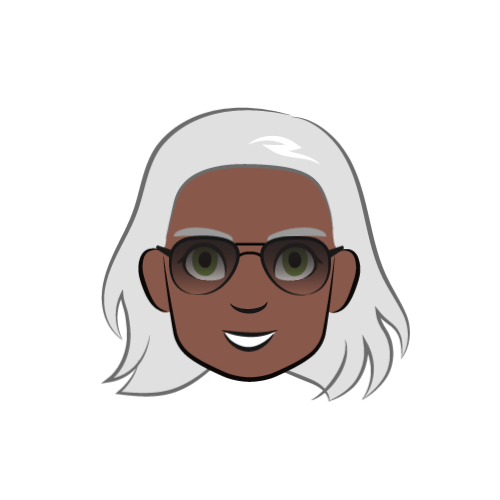

In [18]:
'''
    데이터세트의 출력 값을 시각화 한다.
'''
dataset = CsvDataset(data_root=data_root,
                     annotations=annotations)
data = dataset[0]
data[0]

In [19]:
print(data[1])

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1.])


In [20]:
print(dataset.class_list)

Index(['glasses_0', 'glasses_1', 'glasses_2', 'glasses_3', 'glasses_4',
       'glasses_5', 'glasses_6', 'glasses_7', 'glasses_8', 'glasses_9',
       'glasses_10', 'glasses_11', 'eye_color_0', 'eye_color_1', 'eye_color_2',
       'eye_color_3', 'eye_color_4', 'eyebrow_width_0', 'eyebrow_width_1',
       'eyebrow_width_2'],
      dtype='object')


# 4. 학습 및 검증 데이터 분할

In [21]:
'''
    원본 데이터셋을 학습과 검증셋으로 분할한다.
'''
annotations = annotations.sample(frac=1).reset_index(drop=True)
len_annot = len(annotations)
train_annot = annotations.iloc[ : int(len_annot * 0.9)]
val_annot = annotations.iloc[int(len_annot * 0.9) : ]

print(f'학습 데이터 개수 : {len(train_annot)}')
print(f'검증 데이터 개수 : {len(val_annot)}')

학습 데이터 개수 : 9000
검증 데이터 개수 : 1000


# 5. 모델 학습 준비
1. 학습에 필요한 하이퍼파라미터를 선언한다.</br>
2. 이미지 변환 모듈을 적용한 데이터세트의 샘플을 확인한다.</br>
3. 이미지 변환 모듈을 적용한 학습 및 검증 데이터세트를 생성한다.</br>
4. 학습 및 검증 데이터 로더를 생성한다.


In [22]:
import matplotlib.pyplot as plt
'''
    이미지 시각화 함수를 정의한다. 
'''

def draw_images(images, classes):
    '''
        :param images: cv2(ndarray) 이미지 리스트
        :param classes: 클래스 리스트
        :return: None 
    '''
    # 4x2의 그리드 생성 (바둑판 이미지 틀 생성)
    fig, axs = plt.subplots(2, 4)
    
    # 각 하위 그래프에 이미지 출력
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i]) # 이미지를 바둑판에 출력
        ax.set_title(classes[i]) # 클래스 이름으로 이미지 제목 생성 
        # ax.axis('off') # 축 숨기기
    
    plt.tight_layout()
    plt.show()

In [23]:
'''
    학습에 필요한 하이퍼파라미터를 선언한다.
'''
hyper_params = {
    'num_epochs': 5,
    'lr': 0.0001,
    'score_threshold': 0.5, # 모델의 출력값에 대한 임계값
    'image_size': 128,
    'train_batch_size': 8,
    'val_batch_size': 4,
    'print_preq': 0.1 # 학습 중 로그 출력 빈도
}

In [26]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
'''
    albumentations 이미지 변환 모듈을 적용한 데이터세트의 결과물을 확인한다.
'''

# 샘플 이미지 변환 모듈 설정
sample_transform = A.Compose([
    A.ShiftScaleRotate(p=0.5, border_mode=0),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.Resize(height=hyper_params['image_size'], width=hyper_params['image_size']),
    # A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    # ToTensorV2() ## 모델에 입력할 때 사용
])

sample_dataset = CsvDataset(data_root, train_annot, sample_transform)

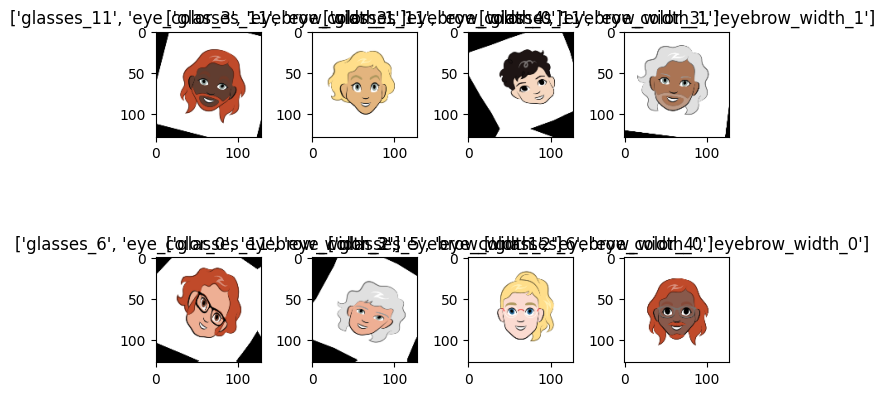

In [29]:
transformed_images = []
targets = []

## 데이터세트에서 변환된 이미지와 target 벡터를 불러온다.
max_cnt = 8
for idx, (image, target) in enumerate(sample_dataset):
    if idx == max_cnt:
        break
    transformed_images.append(image)
    targets.append(target.tolist())

## 타켓 벡터를 클래스로 변환하고 
target_classes = []
class_list = sample_dataset.class_list
for target in targets:
    classes = []
    for cls, val in enumerate(target):
        if int(val) == 1:
            classes.append(class_list[cls])
    target_classes.append(classes)

draw_images(transformed_images, target_classes)

In [45]:
'''
    이미지 변환 모듈을 적용한 학습 및 검증 데이터세트를 생성한다.
    학습 및 검증 데이터 로더를 생성한다.
'''

# 학습 및 검증 이미지 변환 모듈 설정
train_transform = A.Compose([
    A.ShiftScaleRotate(p=0.5, border_mode=0),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.Resize(height=hyper_params['image_size'], width=hyper_params['image_size']),
    A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    ToTensorV2() ## 모델에 입력할 때 사용
])

val_transform = A.Compose([
    A.Resize(height=hyper_params['image_size'], width=hyper_params['image_size']),
    A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    ToTensorV2() ## 모델에 입력할 때 사용
])

# 학습 데이터세트 및 데이터로더 설정
train_dataset = CsvDataset(data_root, train_annot, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hyper_params['train_batch_size'], shuffle=True)

# 검증 데이터세트 및 데이터로더 설정
val_dataset = CsvDataset(data_root, val_annot, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hyper_params['val_batch_size'], shuffle=True)

# 6. 모델 생성
1) Resnet18 모델을 불러온다.</br>
2) 클래스 개수에 맞게 출력 레이어를 변경한다.

In [37]:
import timm
timm.list_models('inception*')[:10]

['inception_next_base',
 'inception_next_small',
 'inception_next_tiny',
 'inception_resnet_v2',
 'inception_v3',
 'inception_v4']

In [38]:
import torch
import torch.nn as nn
from torchvision import models
import timm

'''
    timm 라이브러리로 모델을 불러온다.
'''
def get_model(model_name, num_classes, weight_path='', device='cpu'):
    model = timm.create_model(model_name, 
                              pretrained=True, 
                              num_classes=num_classes)
    if weight_path:
        model.load_state_dict(torch.load(weight_path, map_location='cpu'))
    model.to(device)

    return model

In [39]:
model = get_model('inception_v3', num_classes=train_dataset.num_classes)

In [40]:
model

InceptionV3(
  (Conv2d_1a_3x3): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2a_3x3): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2b_3x3): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size

# 7. 모델 학습 및 검증
   1) loss함수와 옵티마이저를 설정한다.</br>
   2) 학습 루프를 실행한다.</br>
   3) 1 epoch 마다 검증 루프를 실행한다.

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

# loss 함수와 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=hyper_params['lr'])

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = hyper_params['num_epochs']
model_save_dir = './train_results' # epoch 마다 모델 weight를 저장한다.
os.makedirs(model_save_dir, exist_ok=True)
# 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print_cnt = int(len(train_dataloader) * hyper_params['print_preq'])

    for idx, (images, targets) in enumerate(train_dataloader):
        images, targets = images.to(device), targets.to(device)
        
        # 순전파
        outputs = model(images)
        loss = criterion(outputs, targets)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        
        if idx % print_cnt == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Iter [{idx}/{len(train_dataloader)}] "
                  f"Loss: {running_loss/print_cnt:.4f}")
            running_loss = 0.0
        
        

    # 한 epoch이 끝날 때마다 손실값 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")
    
    # 한 epoch이 끝날 때마다 model weight 저장
    model_save_path = os.path.join(model_save_dir, f'{epoch}_model.pth')
    torch.save(model.state_dict(), model_save_path)

    # F1-score 계산 및 출력
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > hyper_params['score_threshold']).float()  # threshold 설정, 여기서는 0.5로 가정
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='micro')  # F1-score 계산
    print(f"F1-score: {f1:.4f}")

Epoch [1/5], Iter [0/1125] Loss: 0.0022
Epoch [1/5], Iter [112/1125] Loss: 0.2211
Epoch [1/5], Iter [224/1125] Loss: 0.2194
Epoch [1/5], Iter [336/1125] Loss: 0.2175
Epoch [1/5], Iter [448/1125] Loss: 0.2047
Epoch [1/5], Iter [560/1125] Loss: 0.2131
Epoch [1/5], Iter [672/1125] Loss: 0.2055
Epoch [1/5], Iter [784/1125] Loss: 0.1967
Epoch [1/5], Iter [896/1125] Loss: 0.1991
Epoch [1/5], Iter [1008/1125] Loss: 0.1887
Epoch [1/5], Iter [1120/1125] Loss: 0.1936
Epoch [1/5], Loss: 0.2060
F1-score: 0.6867
Epoch [2/5], Iter [0/1125] Loss: 0.0024
Epoch [2/5], Iter [112/1125] Loss: 0.1952
Epoch [2/5], Iter [224/1125] Loss: 0.1895
Epoch [2/5], Iter [336/1125] Loss: 0.1923
Epoch [2/5], Iter [448/1125] Loss: 0.1837
Epoch [2/5], Iter [560/1125] Loss: 0.1942
Epoch [2/5], Iter [672/1125] Loss: 0.1863
Epoch [2/5], Iter [784/1125] Loss: 0.1843
Epoch [2/5], Iter [896/1125] Loss: 0.1871
Epoch [2/5], Iter [1008/1125] Loss: 0.1767
Epoch [2/5], Iter [1120/1125] Loss: 0.1768
Epoch [2/5], Loss: 0.1866
F1-scor

In [47]:
import json

'''
    학습 결과 모델과 하이퍼파라미터를 저장한다.
'''

model_save_dir = './train_results'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'model.pth')

torch.save(model.state_dict(), model_save_path)

param_save_path = os.path.join(model_save_dir, 'hyper_params.json') 
with open(param_save_path, 'w')as json_f:
    json.dump(hyper_params, json_f, indent='\t', ensure_ascii=False)

# 8. 모델 테스트
1) 학습한 모델의 가중치를 불러온다.</br>
2) 모델 추론 결과를 확인한다.

In [ ]:
'''
    모델을 선언하고 학습한 모델의 가중치를 불러온다.
'''

model_filename = 'model.pth'

model = get_model('inception_v3', num_classes=train_dataset.num_classes, 
                  weight_path=os.path.join(model_save_dir, model_filename) ,
                  device=device)

In [ ]:
'''
    모델의 추론을 수행한다.
'''
image_list = []
pred_list = []

val_cnt = 8
iter_cnt = 0
with torch.no_grad():
    model.eval()
    for idx, annot in val_annot.iterrows():
        if iter_cnt == val_cnt:
            break
        image_path = os.path.join(data_root, annot['filename'])
        print(f'image_path : {image_path}')
        image = Image.open(image_path)
        image_list.append(image)
        input_image = val_transform(np.array(image))['image'].unsqueeze(0).to(device)

        outputs = torch.sigmoid(model(input_image))[0]
        preds = (outputs > hyper_params['score_threshold']).int().tolist() # threshold 설정
        pred_list.append(preds)

        iter_cnt += 1

In [ ]:
'''
    모델의 추론 결과(클래스 번호)를 클래스 이름으로 변경한다
'''
class_list = train_dataset.class_list
pred_class_list = []
for pred in pred_list:
    pred_class = []
    for cls, val in enumerate(pred):
        if int(val) == 1:
            pred_class.append(class_list[cls])
    pred_class_list.append(pred_class)


In [ ]:
draw_images(image_list, pred_class_list)